# Solving the Incompressible Navier-Stokes Equation with Obstacle using FEniCS

In this notebook, we solve the incompressible Navier-Stokes equation in a channel with a square obstacle using two different approaches. The first approach utilizes a reference mesh, while the second approach employs a Cartesian mesh with a penalized term in the equations to model the obstacle.

# References

1. Hans Petter Langtangen, Anders Logg, "Solving PDEs in Python – The FEniCS Tutorial Volume" (2017).
2. Philippe Angot, Bruneau, "A Penalization Method to Take into Account Obstacles in Incompressible Viscous Flows" (1999).
3. Katuhiko Goda, "A Multistep Technique with Implicit Difference Schemes for Calculating Two- or Three-Dimensional Cavity Flows" (1978).

We utilize the first reference to understand the mathematical theorems and convergence proofs. The second reference provides insights into the FEniCS library, while the third reference explains the variation formulation for the Incompressible Navier-Stokes equation using Chorin's scheme for time discretization.

# To run the program do:
1. Download miniconda from https://docs.conda.io/en/latest/miniconda.html
2. Create a new enviroment: conda create -n enviroment_name
3. Activate the created enviroment: conda activate enviroment_name
4. Install fenics: conda install -c conda-forge fenics
5. Install jupyter lab: conda install jupyterlab
6. To initialize jupyterlab write: jupyter lab

If fenics does not automatically install numpy and matplotlib then it will be necessary to install manually: conda install numpy && conda install matplotlib. The version of fenics installed is the legacy version whose documentation can be found in https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/index.html. You can run the cells sequencially. 

<br>
Begin importing necessary libraries

In [1]:
from dolfin import *
import dolfin
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Print log messages only from the root process in parallel
dolfin.parameters["std_out_all_processes"] = False;

<br>
We are going to define the mesh of the exact solution that we are going to call mesh_ref because it woulb be the reference mesh for our solution. This mesh was generated in Gmsh using triangular elements.


Plotting a ReferenceMesh
46862


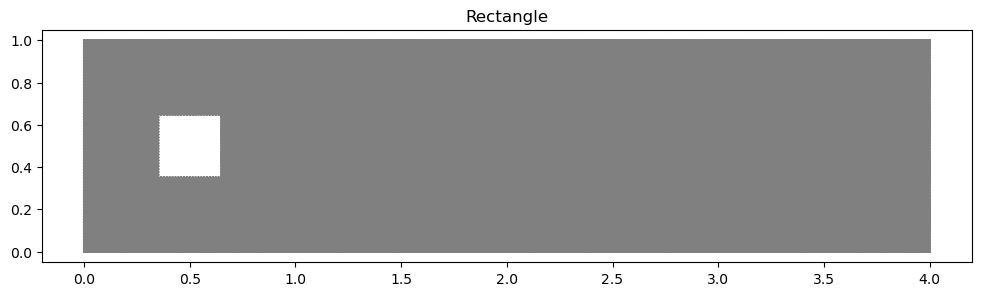

In [3]:
# Define the reference mesh 
mesh_ref = Mesh('mesh/mesh-square.xml')
print("Plotting a ReferenceMesh")

# Print number of elements an plot
print(mesh_ref.num_cells())
fig_ref, ax_ref = plt.subplots(figsize=(12, 4))
dolfin.plot(mesh_ref, title="Rectangle", axes = ax_ref)

<br>
Now we define a rectangular mesh with triangular elements. This mesh will be used as a domain for the Brinkman problem. 

Plotting a RectangleMesh
51200


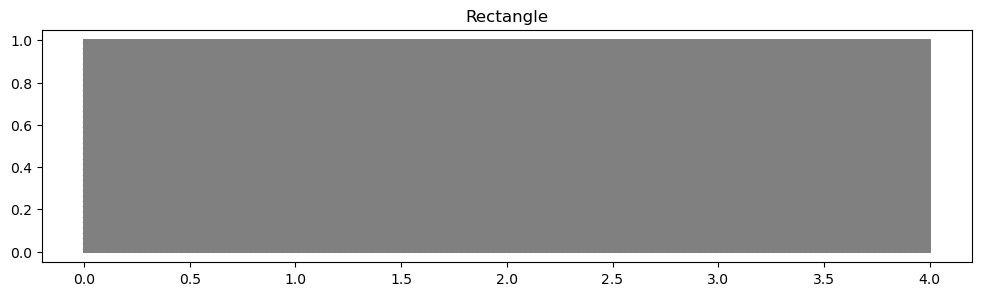

In [4]:
# Create mesh and define function space
mesh_penal = dolfin.RectangleMesh(dolfin.Point(0.0, 0.0), dolfin.Point(4.0, 1.0), 320, 80, "right/left")
print("Plotting a RectangleMesh")

# Print number of elements an plot
print(mesh_penal.num_cells())
fig_penal, ax_penal = plt.subplots(figsize=(12, 4))
dolfin.plot(mesh_penal, title="Rectangle", axes = ax_penal)

<br>
Define the finite element spaces that we are going to use for the reference problem.

In [7]:
# Define function spaces (P2-P1)
V_ref = dolfin.VectorFunctionSpace(mesh_ref, "Lagrange", 2)
Q_ref = dolfin.FunctionSpace(mesh_ref, "Lagrange", 1)

# Define trial and test functions
u_ref = dolfin.TrialFunction(V_ref)
p_ref = dolfin.TrialFunction(Q_ref)
v_ref = dolfin.TestFunction(V_ref)
q_ref = dolfin.TestFunction(Q_ref)

<br>
Define the finite element spaces that we are going to use for the approximated problem.

In [8]:
# Define function spaces (P2-P1)
V_penal = dolfin.VectorFunctionSpace(mesh_penal, "Lagrange", 2)
Q_penal = dolfin.FunctionSpace(mesh_penal, "Lagrange", 1)

# Define trial and test functions
u_penal = dolfin.TrialFunction(V_penal)
p_penal = dolfin.TrialFunction(Q_penal)
v_penal = dolfin.TestFunction(V_penal)
q_penal = dolfin.TestFunction(Q_penal)

<br>
Set the parameters for our problem

In [22]:
# Set the time parameters
dt = 0.001
T = 50 

# Set the fluid parameters 
U0 = 1
D = 0.3 
Re = 80
nu = U0 * D / Re

# print the viscocity
print("The viscocity is nu = {}".format(nu))

The viscocity is nu = 0.00375


<br>
Define the Dirichlet boundary conditions for the velocity and pressure for the reference problem. 

In [10]:
# No-slip boundary condition for velocity
bcu_noslip_top_wall_ref = dolfin.DirichletBC(V_ref, dolfin.Constant((0, 0)), "on_boundary && x[1] > 1.0 - DOLFIN_EPS")
bcu_noslip_bottom_wall_ref = dolfin.DirichletBC(V_ref, dolfin.Constant((0, 0)), "on_boundary && x[1] <  DOLFIN_EPS")
bcu_noslip_hole_ref = DirichletBC(V_ref, dolfin.Constant((0, 0)), "on_boundary && std::abs(x[0] - 0.5) <= 0.15 + DOLFIN_EPS && std::abs(x[1] - 0.5) <= 0.15 + DOLFIN_EPS")

# Inflow boundary condition for velocity
bcu_inflow_ref = dolfin.DirichletBC(V_ref, dolfin.Constant((U0, 0)), "x[0] <  DOLFIN_EPS")

# Outflow boundary condition for pressure
bcp_outflow_ref = dolfin.DirichletBC(Q_ref, dolfin.Constant(0), "x[0] > 4.0 - DOLFIN_EPS")

# Collect boundary conditions
bcu_ref = [bcu_inflow_ref, bcu_noslip_top_wall_ref, bcu_noslip_bottom_wall_ref, bcu_noslip_hole_ref]
bcp_ref = [bcp_outflow_ref]

<br>
Define the Dirichlet boundary conditions for the velocity and pressure for the Brinkman problem. 

In [11]:
# No-slip boundary condition for velocity
bcu_noslip_top_wall_penal = dolfin.DirichletBC(V_penal, dolfin.Constant((0, 0)), "on_boundary && x[1] > 1.0 - DOLFIN_EPS")
bcu_noslip_bottom_wall_penal = dolfin.DirichletBC(V_penal, dolfin.Constant((0, 0)), "on_boundary && x[1] <  DOLFIN_EPS")

# Inflow boundary condition for velocity
bcu_inflow_penal = dolfin.DirichletBC(V_penal, dolfin.Constant((U0, 0)), "x[0] <  DOLFIN_EPS")

# Outflow boundary condition for pressure
bcp_outflow_penal = dolfin.DirichletBC(Q_penal, dolfin.Constant(0), "x[0] > 4.0 - DOLFIN_EPS")

# Collect boundary conditions
bcu_penal = [bcu_inflow_penal, bcu_noslip_top_wall_penal, bcu_noslip_bottom_wall_penal]
bcp_penal = [bcp_outflow_penal]

<br>
Define auxiliary functions to use in the Chorin's method scheme for the time discretization for the incompressible Navier-Stokes equation (reference problem).

In [12]:
# Create auxiliary functions
u0_ref = dolfin.Function(V_ref) # this is the velocity at time n
u1_ref = dolfin.Function(V_ref) # this is the tentative non-divergence free velocity
p1_ref = dolfin.Function(Q_ref) # this is the pressure at time n+1

<br>
Define auxiliary functions to use in the Chorin's method scheme for the time discretization for the incompressible Navier-Stokes equation (penalized problem).

In [13]:
# Create auxiliary functions
u0_penal = dolfin.Function(V_penal) # this is the velocity at time n
u1_penal = dolfin.Function(V_penal) # this is the tentative non-divergence free velocity
p1_penal = dolfin.Function(Q_penal) # this is the pressure at time n+1

In [14]:
# Define coefficients 
k = dolfin.Constant(dt)
f = dolfin.Constant((0.0,0.0))

# Specific coefficients for the penalized problem
chi = dolfin.Expression("(0.5-0.5*std::tanh(10000000.0*(x[0]-0.15-0.5)))\
                        *(0.5+0.5*std::tanh(10000000.0*(x[0]+0.15-0.5)))\
                        *(0.5-0.5*std::tanh(10000000.0*(x[1]-0.15-0.5)))\
                        *(0.5+0.5*std::tanh(10000000.0*(x[1]+0.15-0.5)))", degree=1)    


<br>
Define the variational problem in Chorin's method for the Reference problem. The fisrt step solves for the tentative non-divergence free velocity (in general). The second step is the variational problem for a Poisson equation that solves for the pressure at time m+1. The third step solves the velocity at time m+1.

In [15]:
def set_variational_ref(u, v, p, q, u0, u1, p1, f, Re, k):
    # Tentative velocity step
    F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
         (1/Re)*inner(grad(u), grad(v))*dx - inner(f, v)*dx
    a1 = lhs(F1)
    L1 = rhs(F1)

    # Pressure update
    a2 = inner(grad(p), grad(q))*dx
    L2 = -(1/k)*div(u1)*q*dx

    # Velocity update
    a3 = inner(u, v)*dx
    L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

    a = [a1, a2, a3]
    L = [L1, L2, L3]
    return a, L

<br>
Define the variational problem in Chorin's method for the Brinkman problem. The fisrt step solves for the tentative non-divergence free velocity (in general), note that we are adding a penalized term with an implicit velocity. The second step is the variational problem for a Poisson equation that solves for the pressure at time m+1. The third step solves the velocity at time m+1.   

In [16]:
def set_variational_penal(u, v, p, q, u0, u1, p1, f, eta, chi, Re, k):
    # Tentative velocity step
    F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
         (1/Re)*inner(grad(u), grad(v))*dx + (chi/eta)*inner(u, v)*dx - inner(f, v)*dx
    a1 = lhs(F1)
    L1 = rhs(F1)

    # Pressure update
    a2 = inner(grad(p), grad(q))*dx
    L2 = -(1/k)*div(u1)*q*dx

    # Velocity update
    a3 = inner(u, v)*dx
    L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

    a = [a1, a2, a3]
    L = [L1, L2, L3]
    return a, L

<br>
Assemble the matrices that we are going to use in the linear system that will solve the EDP for the reference problem.

In [17]:
def assemble_matrices(a1, a2, a3):
    # Assemble matrices
    A1 = assemble(a1)
    A2 = assemble(a2)
    A3 = assemble(a3)
    A = [A1, A2, A3]    
    return A

<br>
Define a preconditioner to improve the time computation in solving the linear system.

In [18]:
# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

<br>
Time stepping for the reference solution and for the penalized solution:

In [19]:
def time_stepping(dt, T, A, L, u0, u1, p1, ufile, pfile, bcu, bcp):
# Time-stepping
    t = dt
    time_step = 0
    while t < T + DOLFIN_EPS:       
        # Compute tentative velocity step
        b1 = assemble(L[0])
        [bc.apply(A[0], b1) for bc in bcu]
        solve(A[0], u1.vector(), b1, "bicgstab", "default")

        # Pressure correction
        b2 = assemble(L[1])
        [bc.apply(A[1], b2) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(A[1], p1.vector(), b2, "bicgstab", prec)

        # Velocity correction
        b3 = assemble(L[2])
        [bc.apply(A[2], b3) for bc in bcu]
        solve(A[2], u1.vector(), b3, "bicgstab", "default")

        # Save to file
        if time_step%10 == 0:
            ufile << u1
            pfile << p1
            
        u0.assign(u1)
        t += dt
        time_step += 1
    return u1, p1

<br>
Define functions to plot penalized solutions 

In [20]:
def plot_pressure(p1_penal):
    # Plot solution
    plt.figure(figsize=(12, 4))
    ppp = plot(p1_penal, title="Penalized Pressure")
    ppb = plt.colorbar(ppp, format="%.2f")
    ppb.set_label("Pressure magnitude")
    plt.show()

def plot_velocity(u1_penal):
    # Plot solution
    plt.figure(figsize=(12, 4))
    pvp = plot(u1_penal, title="Penalized Velocity")
    pvb = plt.colorbar(pvp, format="%.2f")
    pvb.set_label("Velocity magnitude")
    plt.show()

<br>
Solve the reference problem an iterate eta for different values, calculate L2 error and plot solutions.

Calling FFC just-in-time (JIT) compiler, this may take some time.
velocity L2 error = 3.76e-01
velocity u_eta L2 norm = 2.14e+00
eta = 0.1


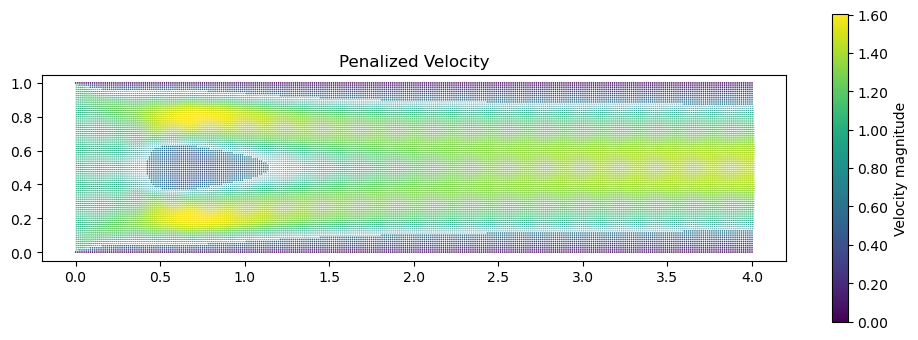

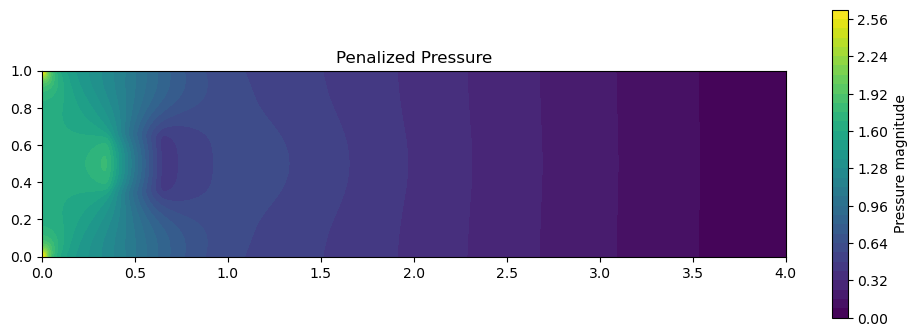

velocity L2 error = 1.32e-01
velocity u_eta L2 norm = 2.19e+00
eta = 0.01


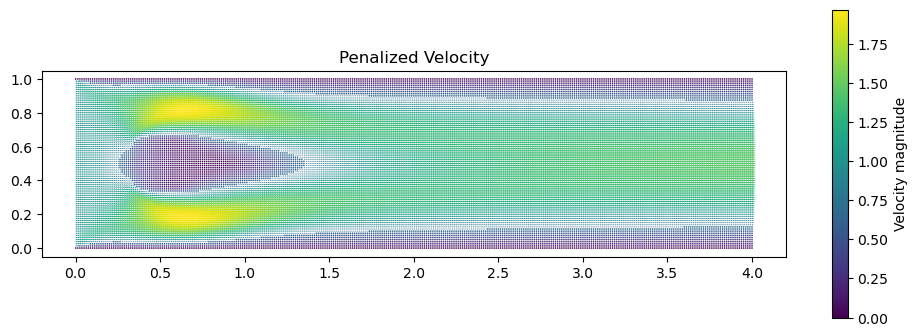

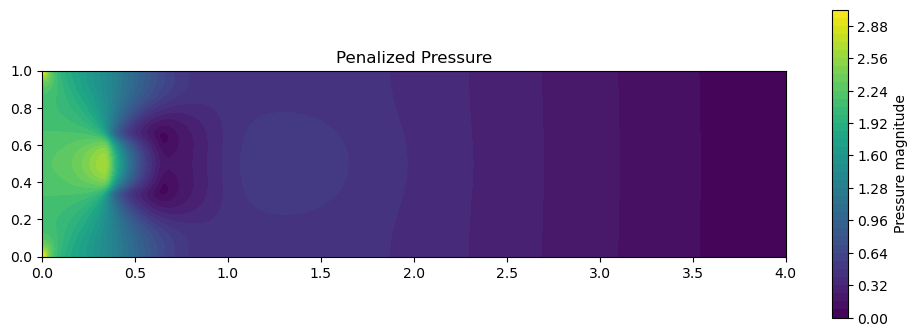

velocity L2 error = 7.20e-02
velocity u_eta L2 norm = 2.21e+00
eta = 0.001


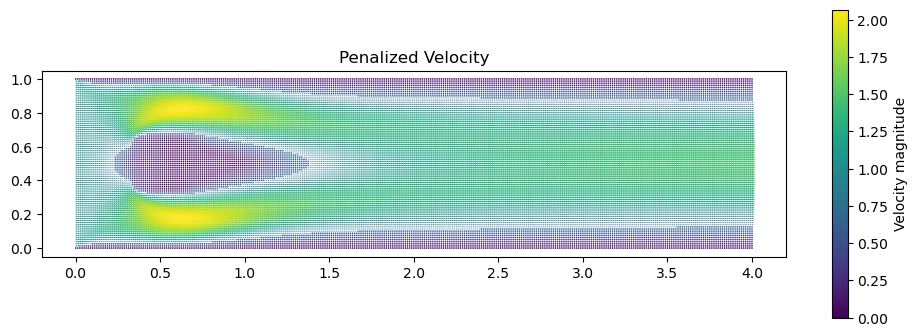

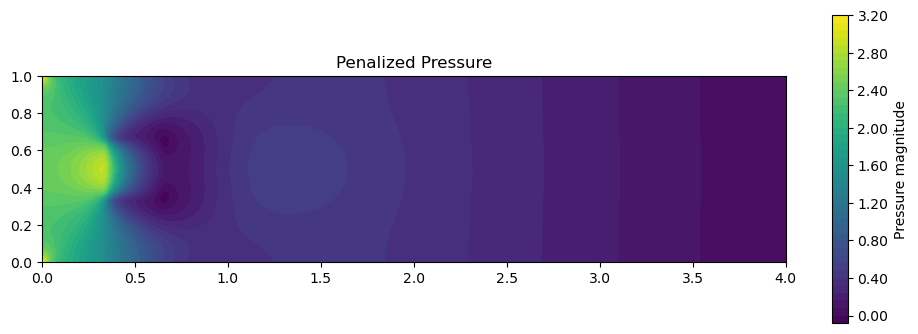

velocity L2 error = 8.47e-02
velocity u_eta L2 norm = 2.22e+00
eta = 0.0001


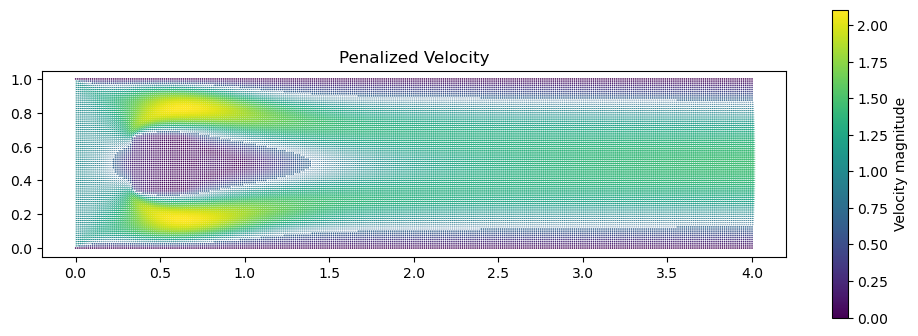

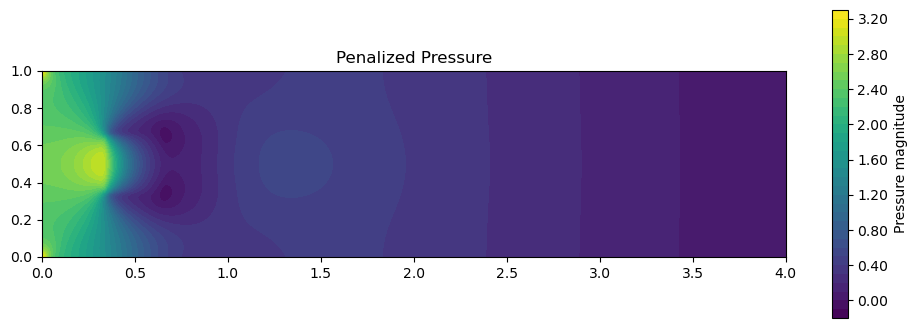

velocity L2 error = 1.01e-01
velocity u_eta L2 norm = 2.22e+00
eta = 1e-05


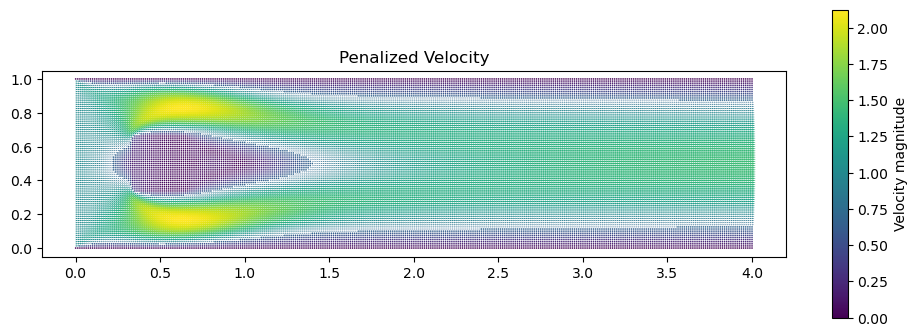

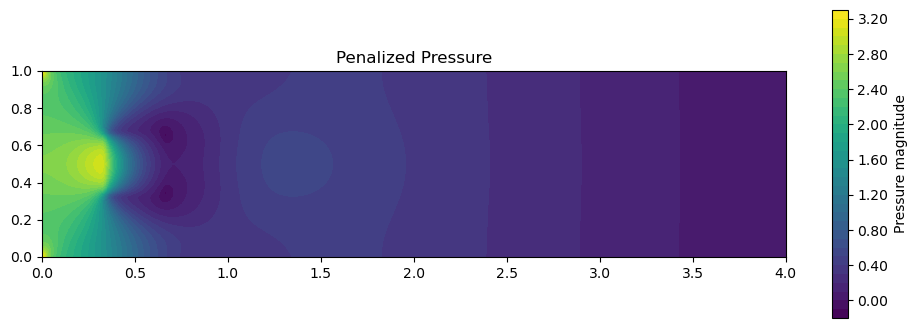

KeyboardInterrupt: 

In [23]:
# Set the reference problem
a_ref, L_ref = set_variational_ref(u_ref, v_ref, p_ref, q_ref, u0_ref, u1_ref, p1_ref, f, Re, k)
A_ref = assemble_matrices(a_ref[0], a_ref[1], a_ref[2])
ufile_ref = File("results_vel_ref/velocity.pvd")
pfile_ref = File("results_vel_ref/pressure.pvd")
u1_ref_last, p1_ref_last = time_stepping(dt, T, A_ref, L_ref, u0_ref, u1_ref, p1_ref, ufile_ref, pfile_ref, bcu_ref, bcp_ref)


eta_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
for eta_brinkman in eta_values:
    eta = dolfin.Constant(eta_brinkman)
    # Create files for storing solution
    ufile_penal = File("results_vel_{}/velocity.pvd".format(eta_brinkman))
    pfile_penal = File("results_vel_{}/pressure.pvd".format(eta_brinkman))
    
    # Set the penalized problem
    a_penal, L_penal = set_variational_penal(u_penal, v_penal, p_penal, q_penal, u0_penal, u1_penal, p1_penal, f, eta, chi, Re, k)
    A_penal = assemble_matrices(a_penal[0], a_penal[1], a_penal[2])
    u1_penal_last, p1_penal_last = time_stepping(dt, T, A_penal, L_penal, u0_penal, u1_penal, p1_penal, ufile_penal, pfile_penal, bcu_penal, bcp_penal)
   
    #project penalized solution on reference domain
    p1_penal_last_proj = dolfin.interpolate(p1_penal_last, Q_ref)
    u1_penal_last_proj = dolfin.interpolate(u1_penal_last, V_ref)

    # Calculate L2 error 
    diff_square = (u1_ref_last - u1_penal_last_proj)**2*dx
    error_L2 = np.sqrt(np.abs(dolfin.assemble(diff_square)))

    # Calculate L2 norm 
    diff_square_norm = (u1_penal_last)**2*dx
    norm_L2 = np.sqrt(np.abs(dolfin.assemble(diff_square_norm)))

    #print L2 error and plot last penalized solution pressure
    print('velocity L2 error = %.2e' % (error_L2))
    print('velocity u_eta L2 norm = %.2e' % (norm_L2))
    print('eta = {}'.format(eta_brinkman))
    plot_velocity(u1_penal)
    plot_pressure(p1_penal)